In [195]:
import pandas as pd
import os, re

In [196]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 11})

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

In [197]:
from IPython.display import IFrame
IFrame("./testbed.pdf", width=600, height=420)

In [198]:
# Metadata for specific SFC configurations
vnfs = ["firewall", "router", "ndpi_stat", "payload_scan", "bridge"]

In [199]:
def parse_seq(file, index=3):
    "Parse sequential data, specialized for the TX/RX/Latency experiments"
    tmp = []
    
    if file.startswith("latency.csv"):
        with open(os.path.join("onvm_global", file)) as f:
            lines = f.readlines()
            for line in lines:
                tmp.append(float(line.strip())/1000)
    else:
        with open(os.path.join("onvm_global", file)) as f:
            next(f)
            for l in f:
                tmp.append(float(l.strip().split(",")[index]))
                
    return tmp

In [200]:
def parse_reg(file, stat_name, index=1):
    "Parse the Perf data"
    stat = []
    with open(os.path.join("onvm_global", file)) as file:
        for line in file:
            if re.search(stat_name, line):
                tmp = line.strip().split(',')[index]
                if tmp.isdigit():
                    stat.append(tmp)
    
    return list(map(lambda x:float(x)/10e9, stat[:-1]))

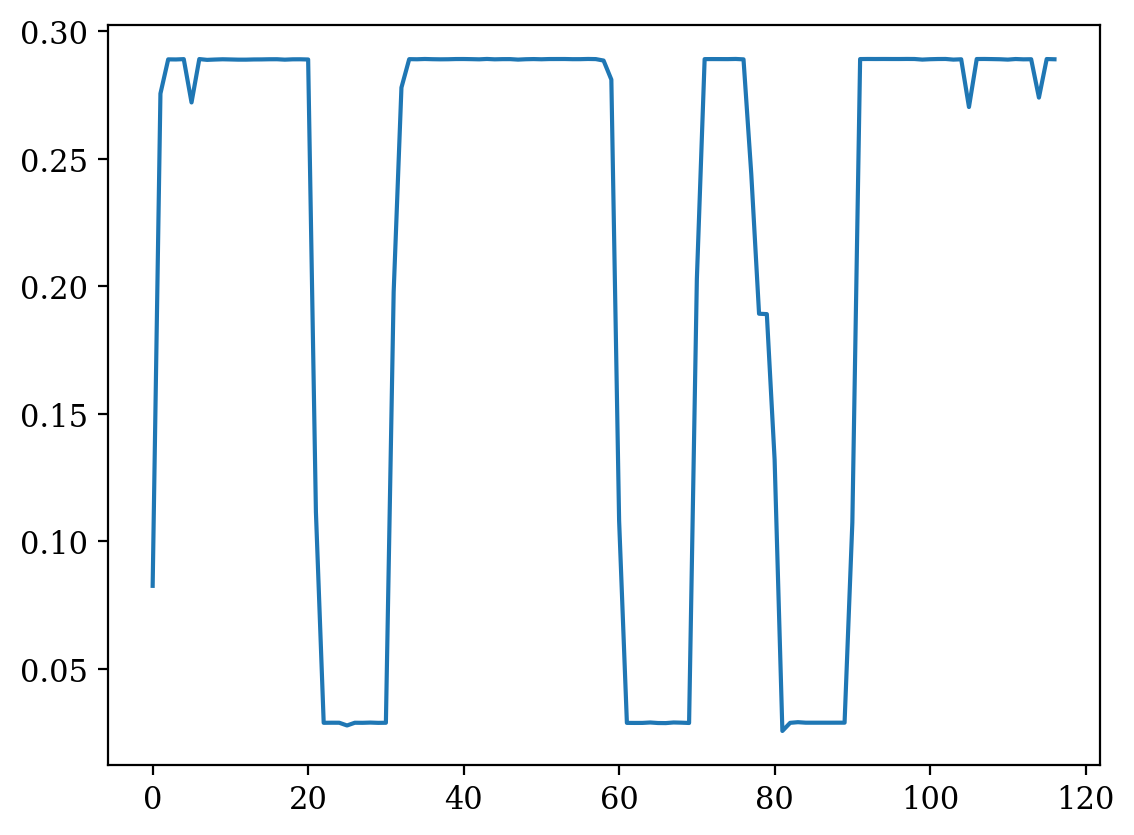

In [201]:
cycles = parse_reg("ndpi_stats.csv", ",cycles,")
plt.plot(cycles)

In [202]:
def parse_onvm(file, nf_name, index=5):
    "Parse the ONVM profiling results"
    nf_stat = []
    with open(os.path.join("onvm_global", file)) as file:
        for line in file:
            if re.search(nf_name, line):
                nf_stat.append(float(line.strip().split(',')[index]))

    return nf_stat

In [203]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [204]:
drop = parse_onvm("nf_out.csv", "bridge", 16)

In [205]:
latency = parse_seq("latency.csv")
len(latency)

85

In [206]:
tx_stats = parse_seq("tx_stats.csv", 3)
len(tx_stats)

118

In [207]:
rx_stats = parse_seq("rx_stats.csv", 3)
len(rx_stats)

118

In [208]:
tmp = parse_onvm("nf_out.csv", "firewall", 5)
tmp = map(lambda x:x/10**6, tmp)
tmp = list(tmp)

In [209]:
def make_df():
    tmp = []
    dic = dict()
    
    tx_stats = parse_seq("tx_stats.csv")[3:]
    rx_stats = parse_seq( "rx_stats.csv")[3:]
                                    
    latency = parse_seq("latency.csv")[3:]
    #normalized_latency = []
    #for i in range(0, len(latency)):
        #if i % 2:
            #normalized_latency.append(latency[i])
    
    seq_length = min([len(parse_onvm("nf_out.csv", "firewall", 5)), \
                      len(tx_stats), \
                      len(rx_stats), \
                      len(latency),
                     ])
    
    print(seq_length)
    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]
    
    for v in vnfs:
        print("NF: ", v)
        tmp = parse_onvm("nf_out.csv", v, 5)[2:]
        dic[v] = tmp[:seq_length]
    
    tmp = []
    for v in vnfs:
        tmp = parse_onvm("nf_out.csv", v, 16)
        dic[v+"_drop"] = tmp[:seq_length]
    
    dic["firewall_cycles"] = parse_reg("firewall.csv", ",cycles,")[:seq_length]
    dic["bridge_cycles"] = parse_reg("bridge.csv", ",cycles,")[:seq_length]
    dic["ndpi_stat_cycles"] = parse_reg("ndpi_stats.csv", ",cycles,")[:seq_length]
    dic["nf_router_cycles"] = parse_reg("nf_router.csv", ",cycles,")[:seq_length]
    dic["payload_scan_cycles"] = parse_reg("payload_scan.csv", ",cycles,")[:seq_length]
    
    return pd.DataFrame(dic)

In [210]:
df = make_df()
df.head(100)

82
NF:  firewall
NF:  router
NF:  ndpi_stat
NF:  payload_scan
NF:  bridge


,input_rate,output_rate,latency,firewall,router,ndpi_stat,payload_scan,bridge,firewall_drop,router_drop,ndpi_stat_drop,payload_scan_drop,bridge_drop,firewall_cycles,bridge_cycles,ndpi_stat_cycles,nf_router_cycles,payload_scan_cycles
0,0.354212,0.354201,192.605,354964.0,283056.0,283024.0,283061.0,283078.0,0.0,0.0,0.0,0.0,0.0,0.049030,0.092664,0.082574,0.084025,0.092821
1,0.353429,0.353077,9.721,353529.0,354978.0,354941.0,354967.0,354967.0,70830.0,0.0,0.0,0.0,0.0,0.231145,0.282430,0.275590,0.276290,0.270226
2,0.353204,0.353406,581.661,353986.0,353521.0,353515.0,353516.0,353510.0,70830.0,0.0,0.0,0.0,0.0,0.285974,0.289010,0.289012,0.288732,0.288902
3,0.354002,0.354060,1098.627,354675.0,353991.0,353955.0,353977.0,353977.0,70830.0,0.0,0.0,0.0,0.0,0.288984,0.289104,0.288974,0.288925,0.289183
4,0.353141,0.352532,76.381,353021.0,354671.0,354653.0,354684.0,354689.0,70830.0,0.0,0.0,0.0,0.0,0.289098,0.289123,0.289099,0.288894,0.288910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,3.112270,3.056550,12.941,3097152.0,3078980.0,3078924.0,3078980.0,3078976.0,70830.0,0.0,26149117.0,0.0,2180352.0,0.289138,0.289130,0.244027,0.288713,0.289073
78,3.118427,1.101767,9.677,1414125.0,3097168.0,3097100.0,3097159.0,3097156.0,70830.0,0.0,26149117.0,0.0,2180352.0,0.288831,0.289130,0.189272,0.288918,0.289052
79,3.120627,0.033600,10.128,711377.0,1399351.0,1399454.0,1189890.0,1173450.0,70830.0,0.0,26149117.0,0.0,2180352.0,0.289143,0.289021,0.189119,0.287917,0.288699
80,3.122416,0.034687,11.095,710511.0,714949.0,714949.0,409575.0,409575.0,70830.0,0.0,26149117.0,0.0,2180352.0,0.289160,0.186762,0.132120,0.288810,0.288992


In [211]:
df = normalize(df)

<AxesSubplot: >

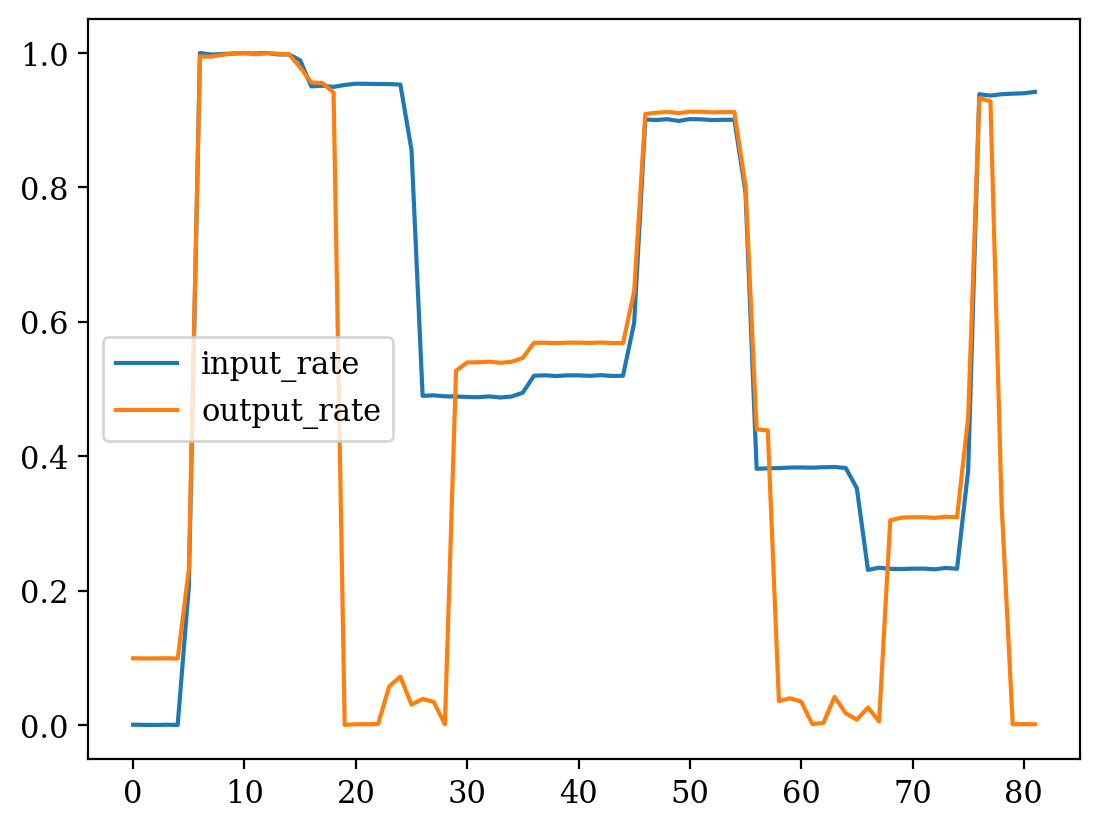

In [212]:
df[["input_rate", "output_rate"]].plot(logy=False)

<AxesSubplot: >

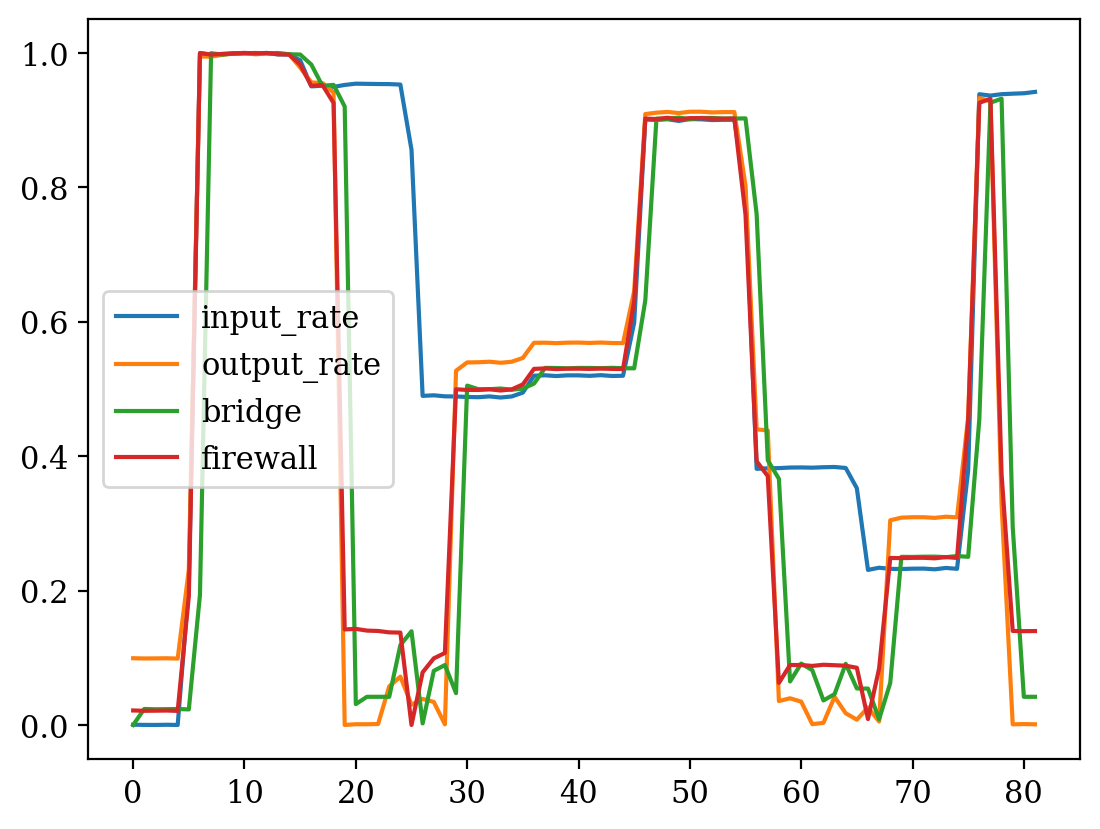

In [213]:
df[["input_rate", "output_rate", "bridge", "firewall"]].plot(logy=False)

<AxesSubplot: >

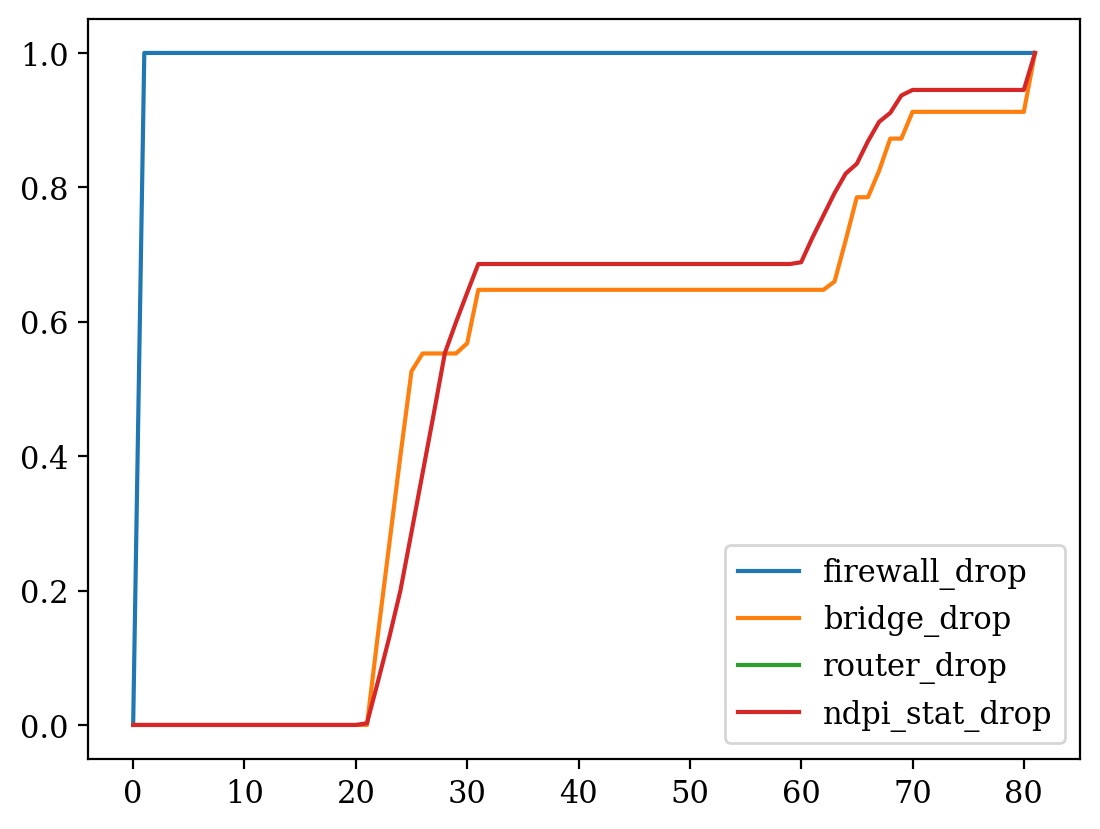

In [214]:
df[["firewall_drop", "bridge_drop", "router_drop", "ndpi_stat_drop"]].plot()

<AxesSubplot: >

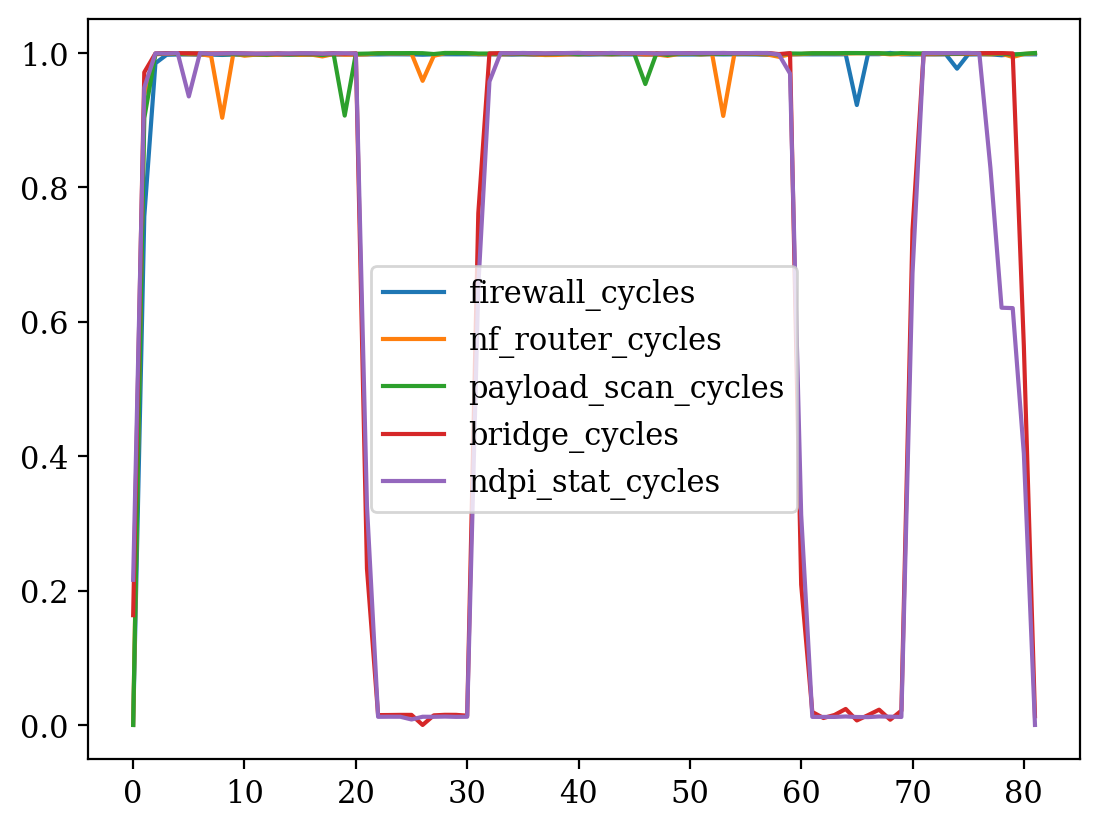

In [215]:
df[[ "firewall_cycles", "nf_router_cycles", "payload_scan_cycles", "bridge_cycles", "ndpi_stat_cycles"]].plot(logy=False)

In [216]:
df.to_csv("onvm_global_two_stresses_bk.csv")